In [1]:
__author__ = "Matteo Pariset"

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.40

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.40


In [3]:
import pandas as pd

from experiment import *
from training import *
from viewer import Viewer
from plotting import *

/home/ubuntu/anaconda3/envs/udsb/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/ubuntu/anaconda3/envs/udsb/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

plt.rcParams["figure.figsize"] = (6.4, 4.8)

plt.rcParams['font.family'] = 'serif'
sns.set_context(context='talk', font_scale=.9)
palette = ['#1A254B', '#114083', '#A7BED3', '#F2545B', '#A4243B']

cmap = LinearSegmentedColormap.from_list('cmap', palette, N=18)

colors = ['#1A254B', '#114083', '#A7BED3', '#FFFFFF', '#F2545B', '#A4243B']
from matplotlib.colors import LinearSegmentedColormap
bcmap = LinearSegmentedColormap.from_list('bcmap', colors, N=100)

# Cancer cell evolution

### Training

In [5]:
# cell_dataset_config = {
#     'dataset_name': 'cells',
#     'state_dims': 50,
#     'killing_function_name': 'trametinib_erlotinib_cells_measurement_density',
# }

# cell_experiment_config = {
#     ## Experiment-dependent variables ############################
#     'objective': "divergence",

#     'times': list(map(lambda t: int(cells_time(t)*100), [8, 24, 48])),
#     'mass': pd.read_csv(f"{SingleCellDataset.get_dataset_name()}_normalized.csv").query(f"Condition == '{SingleCellDataset.get_drug_name()}'")['time'].value_counts().sort_index().to_list(),

#     'init_components_num': 2,
#     'end_components_num': 2,

#     'ipf_mask_dead': False,

#     'ferryman_layers_num': 5,

#     'steps_num': 100,
#     'batch_size': 512,
#     'paths_reuse': 5,
#     'hidden_dims': 300,

#     'eps': 1e-7,
#     'neginf': -25,
#     'plusinf': 15,

#     'experiment_name': f"v4_cell_full_trametinib_erlotinib",
# }

# cell_config = {
#     "dataset": cell_dataset_config,
#     "experiment": cell_experiment_config
# }

In [6]:
# cell_experiment = Experiment.create(cell_config)

In [7]:
# cell_trainer = Trainer(random.PRNGKey(0), cell_experiment)

In [8]:
# cell_trainer.train([1., 1.])

### Inference

In [9]:
cell_experiment = Experiment.load("cells", "v4_cell_full_trametinib_erlotinib__2023_05_11-14_50_19")

[INFO]: Reloading params from cache


In [10]:
cell_viewer = Viewer(random.PRNGKey(0), cell_experiment)

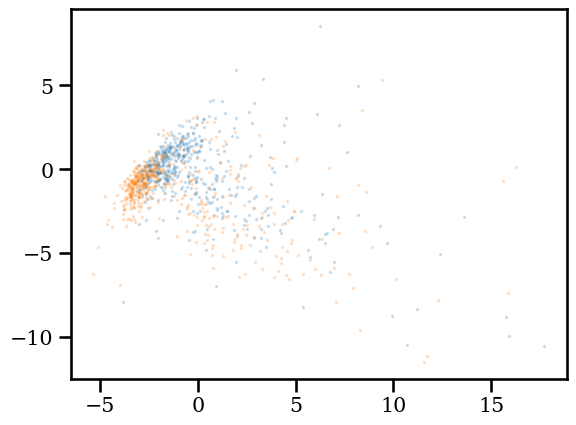

In [11]:
plt.scatter(*cell_experiment.e.project(cell_viewer.get_fresh_marginal(FORWARD)).T, alpha=.2, s=1.)
plt.scatter(*cell_experiment.e.project(cell_viewer.get_fresh_marginal(BACKWARD)).T, alpha=.2, s=1.)

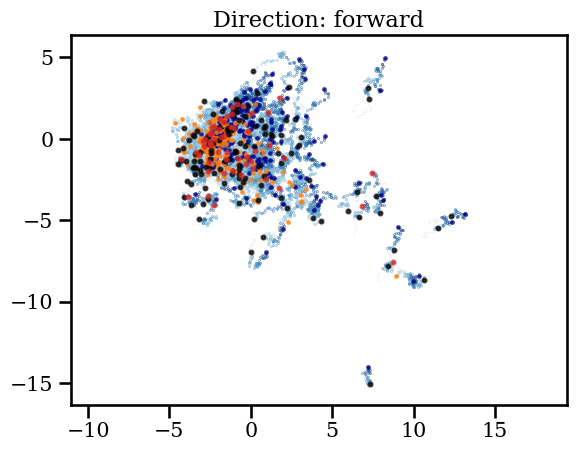

Dead particles. End=0.410 	 Min=0.013 	 Max=0.410


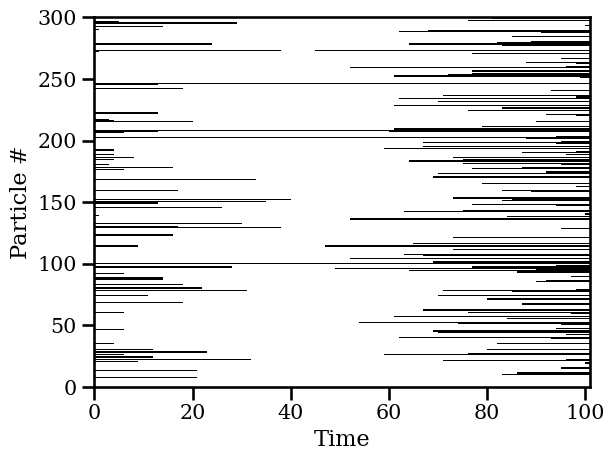

In [12]:
cell_f_trajs, _, cell_f_statuses = cell_viewer.draw_trajectories(FORWARD, timesteps_num=101)

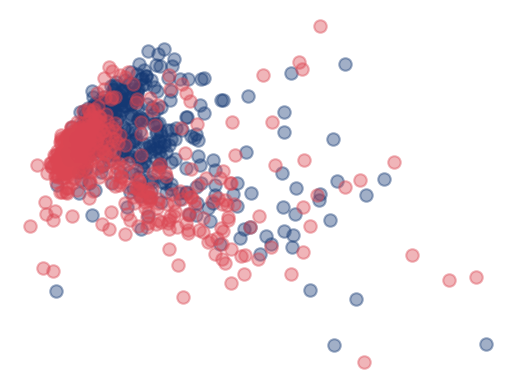

In [13]:
# Ground-truth marginals

plot_marginals(cell_viewer.get_fresh_marginal(FORWARD), cell_viewer.get_fresh_marginal(BACKWARD), projection=cell_experiment.e.project)

plt.axis("off");
plt.gca().legend().remove()
export_fig("usb_cell_marginals_ground_thruth")

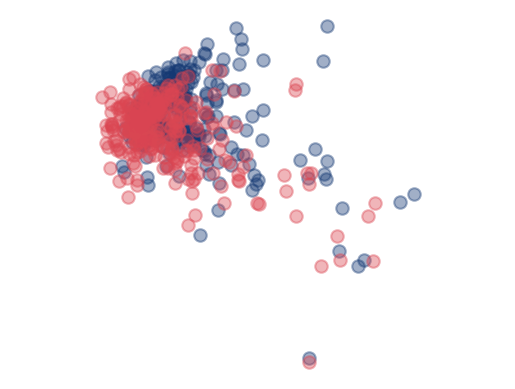

In [14]:
# Predicted marginals

plot_marginals(cell_f_trajs[0], cell_f_trajs[-1], projection=cell_experiment.e.project)

plt.axis("off");
plt.gca().legend().remove()
export_fig("usb_cell_marginals_predicted")

In [15]:
def count_population(viewer, direction):
    many_meas = jnp.stack([viewer.get_fresh_trajectories(direction)[-1].mean(axis=1) for _ in range(5)], axis=0)
    return many_meas.mean(axis=0)

In [16]:
cell_counts = count_population(cell_viewer, FORWARD)

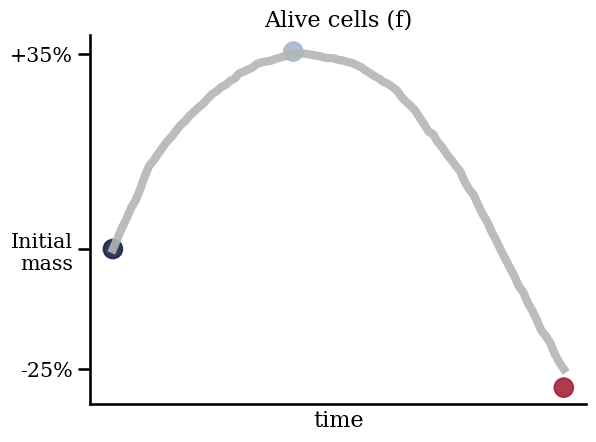

In [17]:
# Plot mass evolution

plt.scatter(cell_experiment.e.times, jnp.array(cell_experiment.e.mass) / cell_experiment.e.mass[0] - 1, s=180, c=bcmap(jnp.array(cell_experiment.e.times)/100), alpha=.9)
plt.plot(cell_counts/cell_counts[0] - 1, lw=6, color=plt.cm.Greys(.4), alpha=.9)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks([])
plt.yticks([0., (cell_counts[int(cell_experiment.e.as_time(24)*100)] / cell_counts[0]) - 1, (cell_counts[int(cell_experiment.e.as_time(48)*100)] / cell_counts[0]) - 1], ['Initial\nmass', '+35%', '-25%'])
plt.xlabel("time")

export_fig("usb_cell_counts")

plt.title("Alive cells (f)");

In [18]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

def mmd_distance(x, y, gamma):
    xx = rbf_kernel(x, x, gamma)
    xy = rbf_kernel(x, y, gamma)
    yy = rbf_kernel(y, y, gamma)

    return xx.mean() + yy.mean() - 2 * xy.mean()

def compute_scalar_mmd(target, transport, gammas=None):
    if gammas is None:
        gammas = [2, 1, 0.5, 0.1, 0.01, 0.005]

    def safe_mmd(*args):
        try:
            mmd = mmd_distance(*args)
        except ValueError:
            mmd = np.nan
        return mmd

    return np.mean(list(map(lambda x: safe_mmd(target, transport, x), gammas)))


def square_norm(vec):
    return np.square(vec).sum(axis=-1)

def compute_rmsd(target, predicted):
    return np.sqrt(square_norm(target-predicted).mean(axis=0))

def compute_norm_rmsd(target, predicted):
    return compute_rmsd(target, predicted) / (np.sqrt(square_norm(target).max()) - np.sqrt(square_norm(target).min()))

# def compute_l2_difference(target, predicted):
#     return np.sqrt(square_norm(target-predicted)).mean(axis=0)

def compute_l2_difference(target, predicted):
    return np.sqrt(square_norm(target.mean(axis=0) - predicted.mean(axis=0)))

import jax
import jax.numpy as jnp
import ott
def make_geometry(t0_points, t1_points):
    """ Set up inital/final cloud points living in space endowed with squared Eucliden distance
    """
    point_cloud = ott.geometry.pointcloud.PointCloud(t0_points, t1_points, ott.geometry.costs.SqEuclidean())
    return point_cloud
def compute_ot(t0_points, t1_points):
    """ Solve OT problem
    """
    point_cloud = make_geometry(t0_points, t1_points)
    sinkhorn = ott.solvers.linear.sinkhorn.Sinkhorn()(ott.problems.linear.linear_problem.LinearProblem(point_cloud))
    return sinkhorn
def transport(ot, init_points):
    return ot.to_dual_potentials().transport(init_points)
def compute_wasserstein_2(preds, true):
    ot = compute_ot(preds, true)
    return jnp.sqrt(ot.transport_cost_at_geom(make_geometry(preds, true))).item()

def compute_metrics(target, predicted):
    return {
        'mmd': compute_scalar_mmd(target, predicted),
        'norm_rmsd': compute_norm_rmsd(target, predicted).item(),
        'l2': compute_l2_difference(target, predicted).item(),
        'w2': compute_wasserstein_2(target, predicted),
    }

In [19]:
# Compute metrics on test set

all_traj_metrics = []
alive_traj_metrics = []

for _ in range(10):
    tmp_time = 48
    tmp_cell_time = int(cells_time(tmp_time)*100)

    cell_viewer.key, key_target_shuffle, key_pred_shuffle = random.split(cell_viewer.key, 3)

    tmp_cell_target = cell_experiment.e.load_measurements(split="test").query(f"Condition == '{cell_experiment.e.get_drug_name()}' and time == {tmp_time}").iloc[:,1:-1].to_numpy()
    tmp_cell_target = random.permutation(key_target_shuffle, tmp_cell_target)

    tmp_cell_pred_trajs, _, tmp_cell_pred_statuses = cell_viewer.get_fresh_trajectories(FORWARD)
    tmp_cell_pred_trajs, tmp_cell_pred_statuses = tmp_cell_pred_trajs[tmp_cell_time], tmp_cell_pred_statuses[tmp_cell_time]

    tmp_cell_pred_trajs = random.permutation(key_pred_shuffle, tmp_cell_pred_trajs)
    tmp_cell_pred_statuses = random.permutation(key_pred_shuffle, tmp_cell_pred_statuses)

    test_size = min(tmp_cell_pred_trajs.shape[0], tmp_cell_target.shape[0])

    all_traj_metrics.append(compute_metrics(tmp_cell_target[:test_size], tmp_cell_pred_trajs[:test_size]))

    alive_traj_metrics.append(compute_metrics(tmp_cell_target[:jnp.minimum(test_size, tmp_cell_pred_statuses.sum())], tmp_cell_pred_trajs[tmp_cell_pred_statuses][:,:jnp.minimum(test_size, tmp_cell_pred_statuses.sum())]))

print("All particles:")
print(pd.DataFrame(all_traj_metrics).apply(lambda r: (r.mean(), r.std())).T.rename({0: "mean", 1:"std"}, axis=1))

print("")

print("Alive only:")
print(pd.DataFrame(alive_traj_metrics).apply(lambda r: (r.mean(), r.std())).T.rename({0: "mean", 1:"std"}, axis=1))

All particles:
               mean       std
mmd        0.018590  0.000761
norm_rmsd  0.353454  0.005649
l2         1.450554  0.063912
w2         6.259158  0.082891

Alive only:
               mean       std
mmd        0.017275  0.000788
norm_rmsd  0.329354  0.030949
l2         1.510472  0.089246
w2         6.171164  0.133615


### Plot full trajectory

In [20]:
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d
from matplotlib.patches import Ellipse

In [21]:
cells_measurements = TrametinibErlotinibDataset.load_measurements()
cells_drug_name = TrametinibErlotinibDataset.get_drug_name()

cells_measurements_8h = jnp.array(cells_measurements.loc[cells_measurements['Condition'] == cells_drug_name].query("time == 8").loc[:,cells_measurements.columns[1:-1]].to_numpy()) # type: ignore
cells_measurements_24h = jnp.array(cells_measurements.loc[cells_measurements['Condition'] == cells_drug_name].query("time == 24").loc[:,cells_measurements.columns[1:-1]].to_numpy()) # type: ignore
cells_measurements_48h = jnp.array(cells_measurements.loc[cells_measurements['Condition'] == cells_drug_name].query("time == 48").loc[:,cells_measurements.columns[1:-1]].to_numpy()) # type: ignore


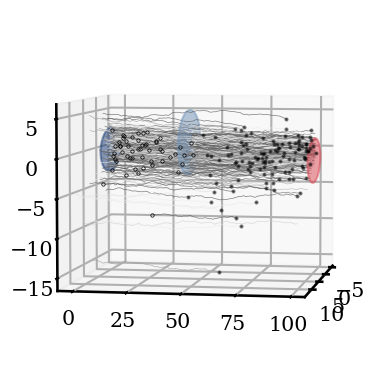

In [108]:
ax = plt.figure().add_subplot(projection='3d', computed_zorder=False)

proj_meas_8h = cell_experiment.e.project(cells_measurements_8h)
proj_meas_24h = cell_experiment.e.project(cells_measurements_24h)
proj_meas_48h = cell_experiment.e.project(cells_measurements_48h)

patch_8 = Ellipse(proj_meas_8h.mean(axis=0), *proj_meas_8h.std(axis=0)*3, alpha=.5, color=cmap(.2), zorder=0)
patch_24 = Ellipse(proj_meas_24h.mean(axis=0), *proj_meas_24h.std(axis=0)*3, alpha=.5, color=cmap(.4), zorder=2)
patch_48 = Ellipse(proj_meas_48h.mean(axis=0), *proj_meas_48h.std(axis=0)*3, alpha=.5, color=cmap(.8), zorder=4)

reduction_factor = 1

plot_keys = []

ax.add_patch(patch_8)
for ts, (traj, curr_stat, next_stat) in enumerate(zip(jnp.einsum("ijk->jki", cell_experiment.e.project(cell_f_trajs)[:42-1,:]), cell_f_statuses[:42-1,:].T, cell_f_statuses[1:42,:].T)):
    cell_viewer.key, tmp_key = random.split(cell_viewer.key)
    plot_keys.append(tmp_key)
    ax.plot3D(traj[0][curr_stat], jnp.arange(0, 41, 1)[curr_stat], traj[1][curr_stat], color=plt.cm.Greys(jnp.clip(random.uniform(tmp_key), .15, .7)), lw=.5, alpha=.8, zorder=1)

ax.add_patch(patch_24)
for ts, (traj, curr_stat, next_stat) in enumerate(zip(jnp.einsum("ijk->jki", cell_experiment.e.project(cell_f_trajs)[40:-1,:]), cell_f_statuses[40:-1,:].T, cell_f_statuses[40+1:,:].T)):
    ax.plot3D(traj[0][curr_stat], jnp.arange(40, 100, 1)[curr_stat], traj[1][curr_stat], color=plt.cm.Greys(jnp.clip(random.uniform(plot_keys[ts]), .15, .7)), lw=.5, alpha=.8, zorder=3)

ax.add_patch(patch_48)

pathpatch_2d_to_3d(patch_8, int(cells_time(8) * 100), 'y')
pathpatch_2d_to_3d(patch_24, int(cells_time(24) * 100), 'y')
pathpatch_2d_to_3d(patch_48, int(cells_time(48)*100), 'y')

for ts, (traj, curr_stat, next_stat) in enumerate(zip(jnp.einsum("ijk->jki", cell_experiment.e.project(cell_f_trajs)[:-1,::reduction_factor]), cell_f_statuses[:-1,::reduction_factor].T, cell_f_statuses[1:,::reduction_factor].T)):
    dying_mask = curr_stat * jnp.logical_not(next_stat)
    birth_mask = jnp.logical_not(curr_stat) * next_stat
    ax.scatter3D(traj[0,dying_mask], jnp.where(dying_mask)[0], traj[1,dying_mask], s=2., alpha=.5, color="black", zorder=4)
    ax.scatter3D(traj[0,birth_mask], jnp.where(birth_mask)[0], traj[1,birth_mask], '+', s=6., linewidths=.5, facecolor="#FFFFFF00", edgecolor="black", zorder=4)

# plt.axis("equal");

ax.view_init(elev=5., azim=10)

export_fig("usb_cells_time_trajs_with_killing")

## Baseline results

Compare performances against standard SB solver by _Chen et al. (2021)_

In [22]:
baseline_trajs = jnp.load("../reproducibility/sb_baseline_cell_pred_trajs.npz", allow_pickle=True)

In [23]:
pd.DataFrame([compute_metrics(tmp_cell_target, baseline_trajs[f'{i}']) for i in range(10)]).apply(lambda r: (r.mean(), r.std())).T.rename({0: "mean", 1:"std"}, axis=1)

,mean,std
mmd,0.018600,0.000375
norm_rmsd,0.353373,0.001829
l2,0.891183,0.033571
w2,6.234721,0.022251


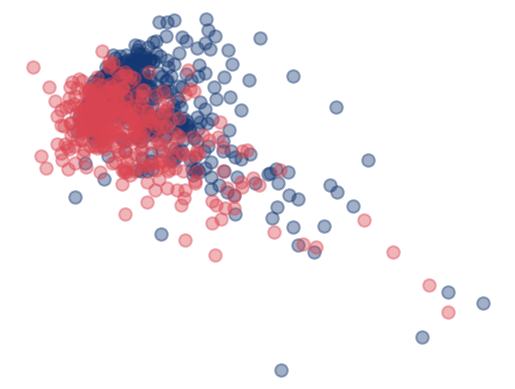

In [24]:
# Baseline predicted marginals

plot_marginals(cell_viewer.get_fresh_marginal(FORWARD), baseline_trajs['0'], projection=cell_experiment.e.project)

plt.axis("off");
plt.gca().legend().remove()
export_fig("sb_baseline_cell_marginals_predicted")